# 1.2 Calibration and Backtesting Analysis

Deep dive into model calibration and simulated trading performance.

## Goals
1. Verify quantile predictions are well-calibrated
2. Simulate trading strategy with realistic costs
3. Analyze edge decay and regime dependence
4. Stress test with different cost assumptions

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns


def find_data_dir(subdir='earnings'):
    """Find the data directory, handling different working directories."""
    candidates = [
        Path(f'../data/{subdir}'),       # From notebooks/
        Path(f'data/{subdir}'),          # From repo root
        Path(f'../../data/{subdir}'),    # From notebooks/runs/
        Path(f'../../../data/{subdir}'), # From notebooks/runs/TIMESTAMP/
    ]
    for p in candidates:
        if p.exists():
            return p.resolve()
    # Return first candidate if none exist (will fail on read with clear error)
    return candidates[0].resolve()


def find_model_dir():
    """Find the models directory, handling different working directories."""
    candidates = [
        Path('../models'),       # From notebooks/
        Path('models'),          # From repo root
        Path('../../models'),    # From notebooks/runs/
        Path('../../../models'), # From notebooks/runs/TIMESTAMP/
    ]
    for p in candidates:
        if p.exists():
            return p.resolve()
    # Return first candidate if none exist
    return candidates[0].resolve()


DATA_DIR = find_data_dir('earnings')
MODEL_DIR = find_model_dir()

print(f"DATA_DIR: {DATA_DIR}")
print(f"MODEL_DIR: {MODEL_DIR}")

In [ ]:
# Parameters (can be overridden by papermill)
USE_CACHE = True

## 1. Load Out-of-Sample Predictions

In [ ]:
# Load predictions from model training
oos_full = pd.read_parquet(DATA_DIR / 'oos_predictions.parquet')
oos_full['earnings_date'] = pd.to_datetime(oos_full['earnings_date'])

print(f"Out-of-sample predictions: {len(oos_full)}")
print(f"Date range: {oos_full['earnings_date'].min().date()} to {oos_full['earnings_date'].max().date()}")
print(f"\nColumns: {list(oos_full.columns)}")

# Phase 4.3: Split OOS data to prevent threshold optimization snooping
# - First 60% (by time) for threshold tuning
# - Last 40% for final unbiased evaluation
oos_full = oos_full.sort_values('earnings_date').reset_index(drop=True)
split_idx = int(len(oos_full) * 0.6)

oos_tune = oos_full.iloc[:split_idx].copy()
oos_final = oos_full.iloc[split_idx:].copy()

print(f"\n=== OOS Data Split for Proper Evaluation ===")
print(f"Tuning set (60%): {len(oos_tune)} rows ({oos_tune['earnings_date'].min().date()} to {oos_tune['earnings_date'].max().date()})")
print(f"Final eval (40%): {len(oos_final)} rows ({oos_final['earnings_date'].min().date()} to {oos_final['earnings_date'].max().date()})")
print(f"→ Use oos_tune for threshold optimization, oos_final for unbiased performance")

# Keep backward compatible 'oos' variable for downstream cells
# But analyses should preferably use oos_tune for selection, oos_final for reporting
oos = oos_full  # Full dataset for general analysis, split for threshold selection

In [3]:
# Also load full features for additional analysis
df_full = pd.read_parquet(DATA_DIR / 'ml_features.parquet')
df_full['earnings_date'] = pd.to_datetime(df_full['earnings_date'])

# IMPORTANT: Deduplicate to prevent Cartesian product in merge
df_full = df_full.drop_duplicates(['symbol', 'earnings_date'], keep='first')

# Merge additional columns
extra_cols = ['timing', 'n_past_earnings', 'rvol_20d', 'pre_earnings_news_count']
extra_cols = [c for c in extra_cols if c in df_full.columns and c not in oos.columns]

if extra_cols:
    oos = oos.merge(
        df_full[['symbol', 'earnings_date'] + extra_cols],
        on=['symbol', 'earnings_date'],
        how='left'
    )

print(f"\nEnriched dataset: {oos.shape}")
print(f"(Should match original OOS size if no duplicates)")


Enriched dataset: (60257, 15)
(Should match original OOS size if no duplicates)


## 2. Calibration Analysis

For each quantile q, we expect (1-q) of actual moves to exceed the prediction.

In [4]:
def compute_calibration_curve(y_true, y_pred, n_bins=10):
    """
    Compute calibration curve: for each bin of predictions,
    what fraction of actuals exceed the prediction?
    """
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')
    
    result = df.groupby('bin', observed=True).agg(
        pred_mean=('y_pred', 'mean'),
        actual_mean=('y_true', 'mean'),
        exceedance_rate=('y_true', lambda x: (x > df.loc[x.index, 'y_pred']).mean()),
        count=('y_true', 'count'),
    ).reset_index()
    
    return result

In [5]:
# Overall calibration
quantiles = [0.50, 0.75, 0.90, 0.95]

print("=== Overall Calibration ===")
print(f"{'Quantile':<10} {'Expected':<12} {'Actual':<12} {'Error':<12}")
print("-" * 50)

for q in quantiles:
    col = f'pred_q{int(q*100)}'
    if col not in oos.columns:
        continue
    
    expected = 1 - q
    actual = (oos['target_move'] > oos[col]).mean()
    error = actual - expected
    
    print(f"q{int(q*100):<8} {expected:<12.2%} {actual:<12.2%} {error:+.2%}")

=== Overall Calibration ===
Quantile   Expected     Actual       Error       
--------------------------------------------------
q50       50.00%       51.24%       +1.24%
q75       25.00%       27.72%       +2.72%
q90       10.00%       12.76%       +2.76%
q95       5.00%        7.37%        +2.37%


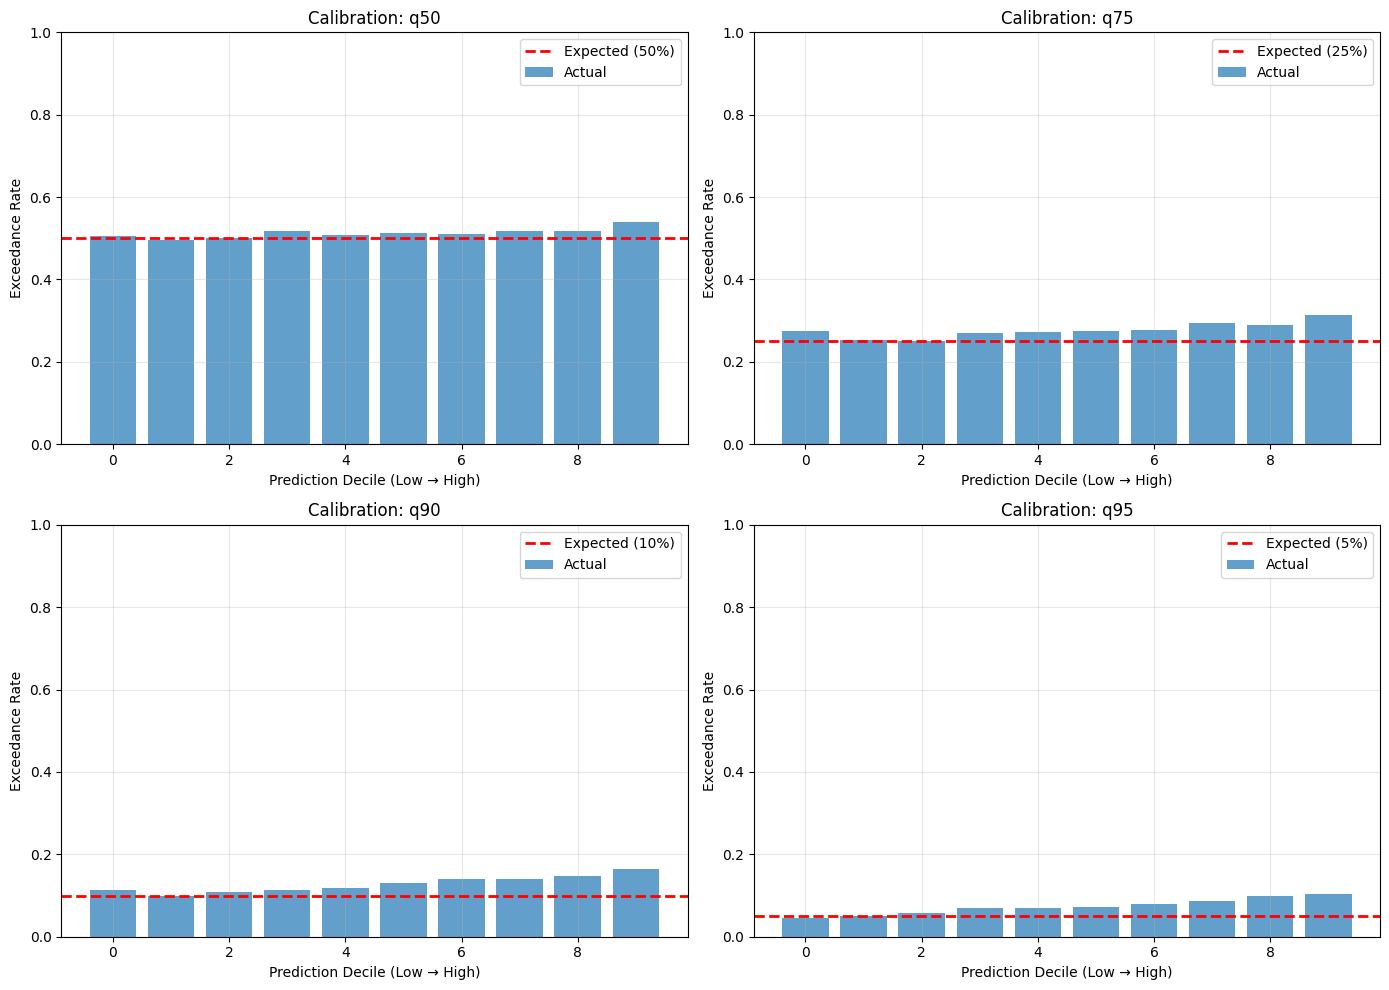

In [6]:
# Calibration by prediction bin
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, q in enumerate(quantiles):
    ax = axes[i // 2, i % 2]
    col = f'pred_q{int(q*100)}'
    
    if col not in oos.columns:
        continue
    
    calib = compute_calibration_curve(oos['target_move'].values, oos[col].values)
    
    # Plot exceedance rate vs prediction
    ax.bar(range(len(calib)), calib['exceedance_rate'], alpha=0.7, label='Actual')
    ax.axhline(1 - q, color='r', linestyle='--', linewidth=2, label=f'Expected ({(1-q):.0%})')
    
    ax.set_xlabel('Prediction Decile (Low → High)')
    ax.set_ylabel('Exceedance Rate')
    ax.set_title(f'Calibration: q{int(q*100)}')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'calibration_by_bin.png', dpi=100)
plt.show()

## 3. Calibration by Segment

Check if calibration holds across different segments.

In [7]:
def compute_segment_calibration(df, segment_col, q=0.75):
    """
    Compute calibration metrics by segment.
    """
    col = f'pred_q{int(q*100)}'
    if col not in df.columns:
        return None
    
    expected = 1 - q
    
    results = []
    for segment, grp in df.groupby(segment_col):
        if len(grp) < 20:  # Need minimum samples
            continue
        
        actual = (grp['target_move'] > grp[col]).mean()
        error = actual - expected
        
        results.append({
            'segment': segment,
            'count': len(grp),
            'expected': expected,
            'actual': actual,
            'error': error,
            'abs_error': abs(error),
        })
    
    return pd.DataFrame(results)

In [8]:
# Calibration by timing (BMO vs AMC)
if 'timing' in oos.columns:
    timing_calib = compute_segment_calibration(oos, 'timing', q=0.75)
    if timing_calib is not None and len(timing_calib) > 0:
        print("=== Calibration by Timing (q75) ===")
        print(timing_calib.to_string(index=False))

=== Calibration by Timing (q75) ===
segment  count  expected   actual    error  abs_error
    AMC  26463      0.25 0.285342 0.035342   0.035342
    BMO  19549      0.25 0.273518 0.023518   0.023518
unknown  14245      0.25 0.267181 0.017181   0.017181


In [9]:
# Calibration by history depth
if 'n_past_earnings' in oos.columns:
    oos['history_bucket'] = pd.cut(
        oos['n_past_earnings'],
        bins=[0, 2, 4, 8, 100],
        labels=['1-2', '3-4', '5-8', '9+']
    )
    
    history_calib = compute_segment_calibration(oos, 'history_bucket', q=0.75)
    if history_calib is not None and len(history_calib) > 0:
        print("\n=== Calibration by History Depth (q75) ===")
        print(history_calib.to_string(index=False))


=== Calibration by History Depth (q75) ===
segment  count  expected   actual    error  abs_error
    1-2   1836      0.25 0.300109 0.050109   0.050109
    3-4   5174      0.25 0.298029 0.048029   0.048029
    5-8  15584      0.25 0.293442 0.043442   0.043442
     9+  37663      0.25 0.266522 0.016522   0.016522


In [10]:
# Calibration over time (rolling)
oos_sorted = oos.sort_values('earnings_date').copy()

# Rolling calibration with 200-trade window
window = 200

rolling_calib = []
for i in range(window, len(oos_sorted)):
    window_df = oos_sorted.iloc[i-window:i]
    date = oos_sorted.iloc[i]['earnings_date']
    
    for q in [0.75, 0.90]:
        col = f'pred_q{int(q*100)}'
        if col in window_df.columns:
            expected = 1 - q
            actual = (window_df['target_move'] > window_df[col]).mean()
            
            rolling_calib.append({
                'date': date,
                'quantile': q,
                'expected': expected,
                'actual': actual,
                'error': actual - expected,
            })

rolling_df = pd.DataFrame(rolling_calib)
print(f"\nRolling calibration: {len(rolling_df)} observations")


Rolling calibration: 120114 observations


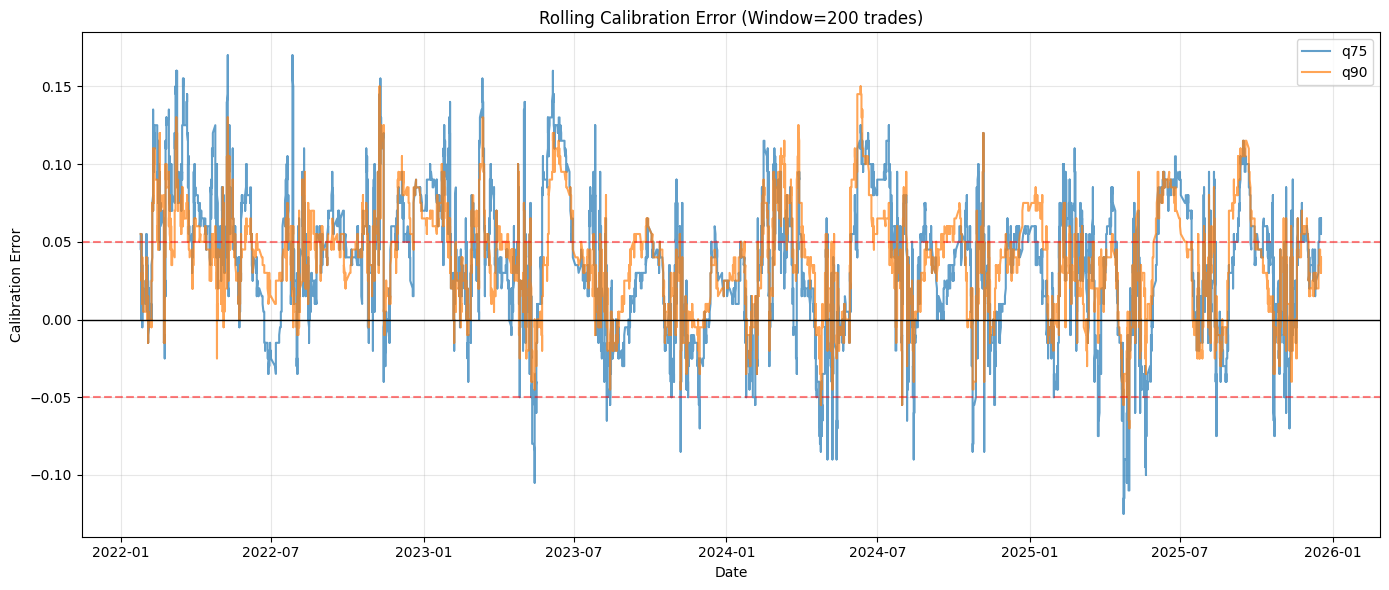

In [11]:
# Plot rolling calibration
if len(rolling_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for q in [0.75, 0.90]:
        subset = rolling_df[rolling_df['quantile'] == q]
        ax.plot(subset['date'], subset['error'], label=f'q{int(q*100)}', alpha=0.7)
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.axhline(0.05, color='red', linestyle='--', alpha=0.5)
    ax.axhline(-0.05, color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Calibration Error')
    ax.set_title(f'Rolling Calibration Error (Window={window} trades)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'rolling_calibration.png', dpi=100)
    plt.show()

## 4. Trading Simulation

Simulate the strategy with realistic cost assumptions.

In [12]:
def simulate_strategy(df, 
                     edge_threshold=0.0,
                     implied_move_multiplier=1.0,  # Options premium over historical
                     spread_cost_pct=0.03,  # 3% round-trip spread
                     commission_per_contract=1.30,  # IBKR commission per contract
                     contracts_per_trade=2,  # Straddle = 2 contracts
                     notional_per_trade=5000,  # $ notional for commission calc
                     max_trades_per_day=5):
    """
    Simulate straddle trading strategy.
    
    Args:
        df: DataFrame with predictions
        edge_threshold: Minimum edge to trade (pred_q75 - implied)
        implied_move_multiplier: Options implied move as multiple of hist_move_mean
            - 1.0 = implied equals historical (optimistic)
            - 1.3 = 30% volatility premium (realistic)
            - 1.5 = 50% volatility premium (conservative)
        spread_cost_pct: Round-trip spread cost as % of spot
        commission_per_contract: IBKR commission per option contract
        contracts_per_trade: Number of contracts per straddle (2 for straddle)
        notional_per_trade: Assumed $ notional per trade for commission calc
        max_trades_per_day: Position limit
    
    Returns:
        DataFrame with trade results
    """
    df = df.copy()
    
    # Implied move (proxy) - apply multiplier for vol premium
    df['implied_move'] = df['hist_move_mean'] * implied_move_multiplier
    
    # Edge calculation - compare prediction to IMPLIED move (not historical)
    df['edge'] = df['pred_q75'] - df['implied_move']
    
    # Filter to tradeable candidates
    df['tradeable'] = df['edge'] > edge_threshold
    
    # Limit trades per day
    df = df.sort_values(['earnings_date', 'edge'], ascending=[True, False])
    df['trade_rank'] = df.groupby('earnings_date').cumcount() + 1
    df['take_trade'] = df['tradeable'] & (df['trade_rank'] <= max_trades_per_day)
    
    # P&L calculation
    # Payoff = |actual_move|
    # Cost = implied_move + spread + commission
    commission_pct = (commission_per_contract * contracts_per_trade * 2) / notional_per_trade  # *2 for entry+exit
    
    df['payoff'] = df['target_move']
    df['total_cost'] = df['implied_move'] + spread_cost_pct + commission_pct
    df['pnl'] = df['payoff'] - df['total_cost']
    df['pnl_if_trade'] = df['pnl'] * df['take_trade']
    
    return df

In [13]:
# Base case simulation (OPTIMISTIC: 1.0x implied move = historical)
sim = simulate_strategy(
    oos,
    edge_threshold=0.05,  # 5% minimum edge
    implied_move_multiplier=1.0,  # Optimistic: Implied = historical
    spread_cost_pct=0.03,  # 3% spread cost
    max_trades_per_day=5,
)

trades = sim[sim['take_trade']].copy()

print("=== Strategy Simulation (OPTIMISTIC: 1.0x implied move) ===")
print(f"Total candidates: {len(oos)}")
print(f"Trades taken: {len(trades)} ({len(trades)/len(oos)*100:.1f}%)")
print(f"\nP&L Statistics:")
print(f"  Mean P&L per trade: {trades['pnl'].mean():.2%}")
print(f"  Median P&L per trade: {trades['pnl'].median():.2%}")
print(f"  Std P&L: {trades['pnl'].std():.2%}")
print(f"  Win rate: {(trades['pnl'] > 0).mean():.1%}")
print(f"\nTotal P&L (sum): {trades['pnl'].sum():.2%}")
print("\n⚠️  NOTE: This uses optimistic 1.0x implied move. See Section 5.2 for realistic assumptions.")

=== Strategy Simulation (OPTIMISTIC: 1.0x implied move) ===
Total candidates: 60257
Trades taken: 2654 (4.4%)

P&L Statistics:
  Mean P&L per trade: 1.09%
  Median P&L per trade: -1.22%
  Std P&L: 9.86%
  Win rate: 43.9%

Total P&L (sum): 2892.44%

⚠️  NOTE: This uses optimistic 1.0x implied move. See Section 5.2 for realistic assumptions.


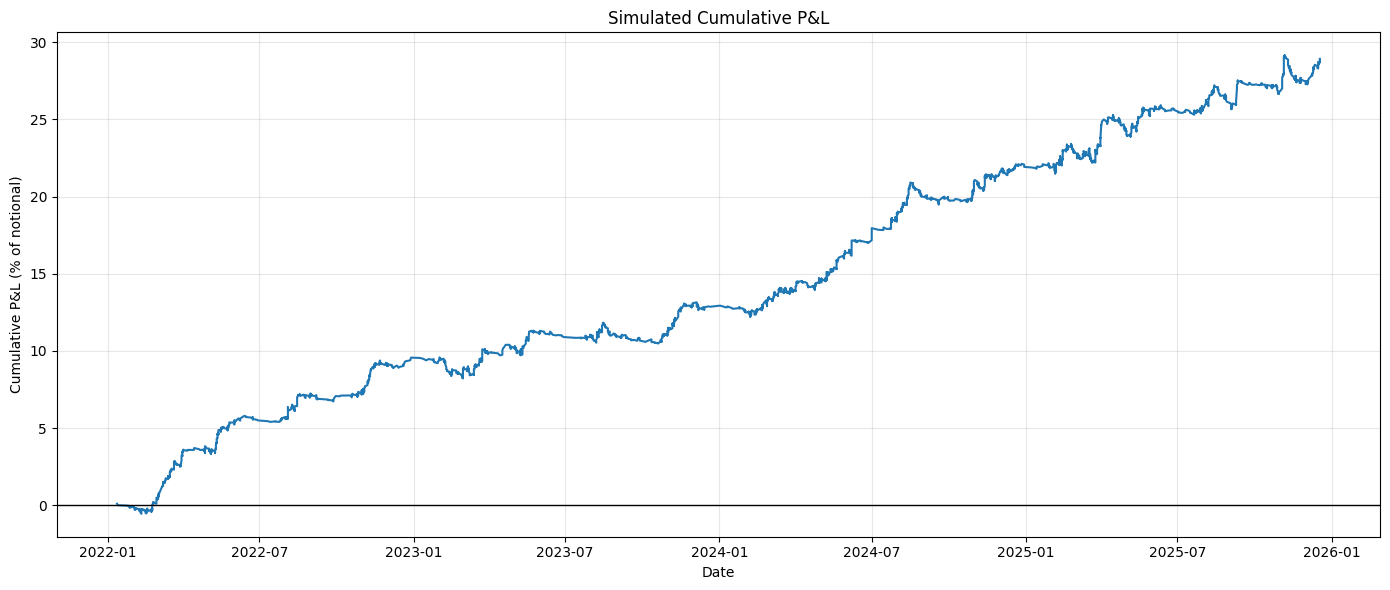

In [14]:
# Cumulative P&L
trades_sorted = trades.sort_values('earnings_date')
trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(trades_sorted['earnings_date'], trades_sorted['cum_pnl'])
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (% of notional)')
plt.title('Simulated Cumulative P&L')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(DATA_DIR / 'cumulative_pnl.png', dpi=100)
plt.show()

## 5. Sensitivity Analysis

How sensitive is P&L to cost assumptions?

## 5.1 Edge Threshold Evaluation

Systematic analysis of different edge thresholds to find optimal trade-off between trade quality and quantity.

In [ ]:
# Evaluate different edge thresholds ON TUNING SET ONLY (Phase 4.3)
# This prevents threshold optimization snooping - final eval uses separate data
thresholds = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.10]

threshold_results = []
for thresh in thresholds:
    # USE oos_tune FOR THRESHOLD SELECTION (not full oos!)
    sim = simulate_strategy(oos_tune, edge_threshold=thresh, spread_cost_pct=0.03)
    trades = sim[sim['take_trade']].copy()
    
    if len(trades) == 0:
        continue
    
    # Sort for drawdown calc
    trades_sorted = trades.sort_values('earnings_date')
    trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()
    trades_sorted['high_water'] = trades_sorted['cum_pnl'].cummax()
    trades_sorted['drawdown'] = trades_sorted['cum_pnl'] - trades_sorted['high_water']
    
    # Daily P&L for Sharpe
    daily_pnl = trades.groupby('earnings_date')['pnl'].sum()
    n_days = len(daily_pnl)
    n_calendar = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(trades_per_year) if daily_pnl.std() > 0 else 0
    
    threshold_results.append({
        'threshold': thresh,
        'n_trades': len(trades),
        'mean_pnl': trades['pnl'].mean(),
        'median_pnl': trades['pnl'].median(),
        'win_rate': (trades['pnl'] > 0).mean(),
        'total_pnl': trades['pnl'].sum(),
        'max_dd': trades_sorted['drawdown'].min(),
        'sharpe': sharpe,
        'avg_edge': trades['edge'].mean(),
    })

threshold_df = pd.DataFrame(threshold_results)

print("=== Edge Threshold Analysis on TUNING SET (3% spread cost) ===")
print("(Phase 4.3: Using oos_tune to select threshold, oos_final for unbiased eval)\n")
print(threshold_df.to_string(index=False, formatters={
    'threshold': '{:.0%}'.format,
    'mean_pnl': '{:+.2%}'.format,
    'median_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.1%}'.format,
    'max_dd': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'avg_edge': '{:.2%}'.format,
}))

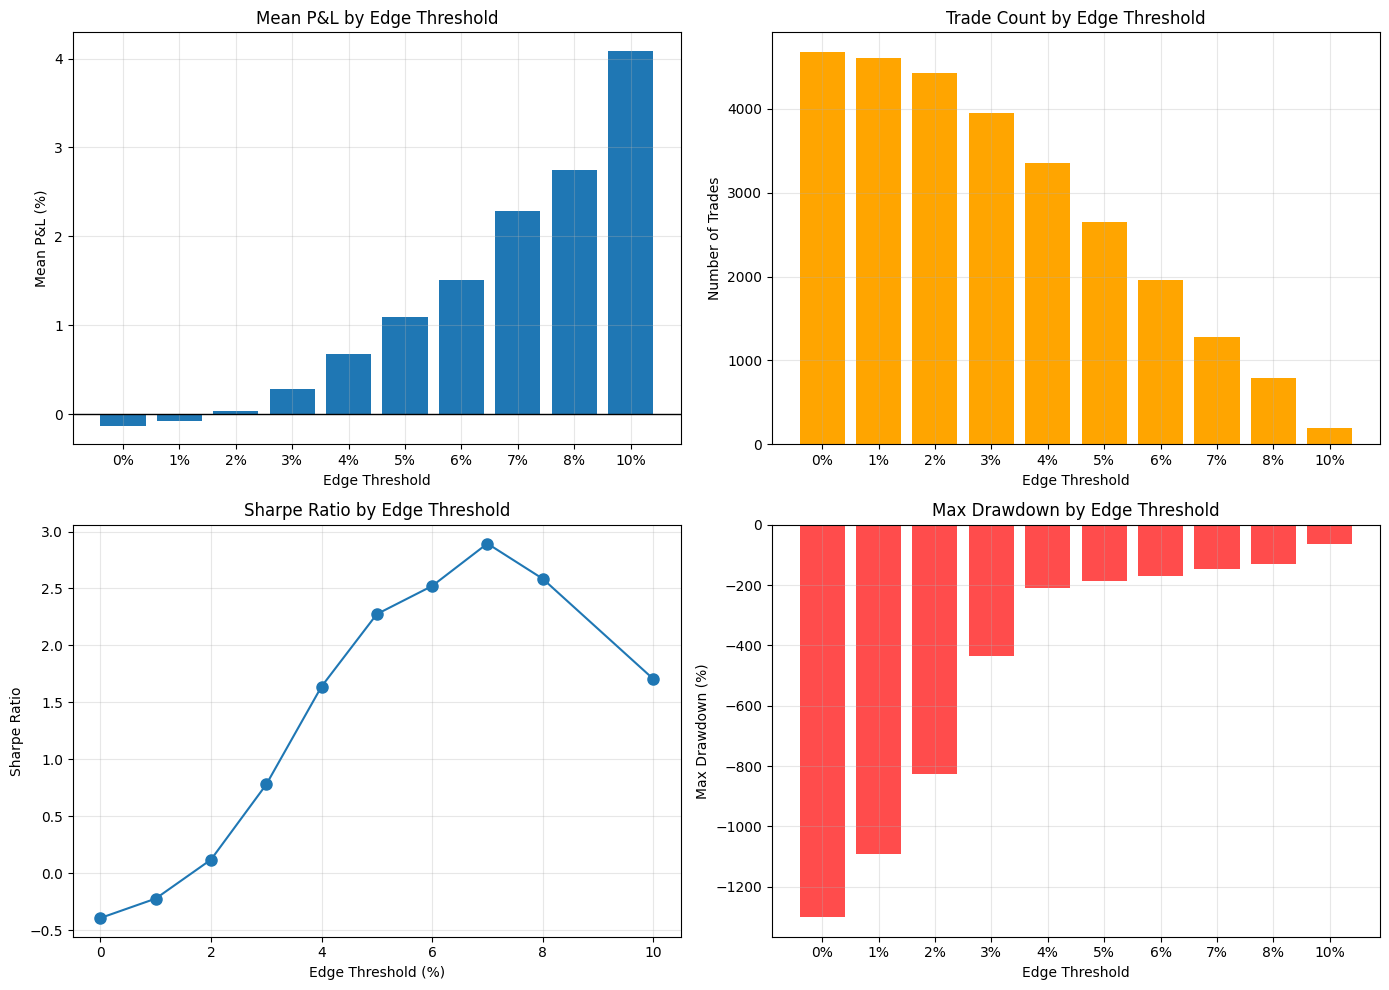

In [16]:
# Plot threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean P&L vs Threshold
ax = axes[0, 0]
ax.bar(range(len(threshold_df)), threshold_df['mean_pnl'] * 100)
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Mean P&L (%)')
ax.set_title('Mean P&L by Edge Threshold')
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3)

# Number of trades vs Threshold
ax = axes[0, 1]
ax.bar(range(len(threshold_df)), threshold_df['n_trades'], color='orange')
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Number of Trades')
ax.set_title('Trade Count by Edge Threshold')
ax.grid(True, alpha=0.3)

# Sharpe vs Threshold
ax = axes[1, 0]
ax.plot(threshold_df['threshold'] * 100, threshold_df['sharpe'], 'o-', markersize=8)
ax.set_xlabel('Edge Threshold (%)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio by Edge Threshold')
ax.grid(True, alpha=0.3)

# Max Drawdown vs Threshold
ax = axes[1, 1]
ax.bar(range(len(threshold_df)), threshold_df['max_dd'] * 100, color='red', alpha=0.7)
ax.set_xticks(range(len(threshold_df)))
ax.set_xticklabels([f"{t:.0%}" for t in threshold_df['threshold']])
ax.set_xlabel('Edge Threshold')
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Max Drawdown by Edge Threshold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'threshold_analysis.png', dpi=100)
plt.show()

In [ ]:
# Find optimal thresholds ON TUNING SET
print("=== Threshold Recommendations (from Tuning Set) ===\n")

# Best Sharpe
best_sharpe_idx = threshold_df['sharpe'].idxmax()
best_sharpe = threshold_df.loc[best_sharpe_idx]
print(f"Best Sharpe ({best_sharpe['sharpe']:.2f}): {best_sharpe['threshold']:.0%} threshold")
print(f"  - {int(best_sharpe['n_trades'])} trades, {best_sharpe['mean_pnl']:.2%} mean P&L, {best_sharpe['win_rate']:.1%} win rate")

# Store optimal threshold for use in final evaluation
OPTIMAL_THRESHOLD = best_sharpe['threshold']

# Phase 4.3: UNBIASED EVALUATION on oos_final
print("\n" + "=" * 60)
print("UNBIASED FINAL EVALUATION (on held-out oos_final)")
print("=" * 60)

# Run simulation on final evaluation set with selected threshold
sim_final = simulate_strategy(oos_final, edge_threshold=OPTIMAL_THRESHOLD, spread_cost_pct=0.03)
trades_final = sim_final[sim_final['take_trade']].copy()

if len(trades_final) > 0:
    # Sharpe on final set
    daily_pnl_final = trades_final.groupby('earnings_date')['pnl'].sum()
    n_days_final = len(daily_pnl_final)
    n_calendar_final = (trades_final['earnings_date'].max() - trades_final['earnings_date'].min()).days
    trades_per_year_final = n_days_final * 252 / n_calendar_final if n_calendar_final > 0 else 100
    sharpe_final = (daily_pnl_final.mean() / daily_pnl_final.std()) * np.sqrt(trades_per_year_final) if daily_pnl_final.std() > 0 else 0
    
    # Max drawdown
    trades_final_sorted = trades_final.sort_values('earnings_date')
    trades_final_sorted['cum_pnl'] = trades_final_sorted['pnl'].cumsum()
    trades_final_sorted['high_water'] = trades_final_sorted['cum_pnl'].cummax()
    trades_final_sorted['drawdown'] = trades_final_sorted['cum_pnl'] - trades_final_sorted['high_water']
    
    print(f"\nSelected threshold: {OPTIMAL_THRESHOLD:.0%}")
    print(f"Final eval period: {trades_final['earnings_date'].min().date()} to {trades_final['earnings_date'].max().date()}")
    print(f"\nResults on UNSEEN data:")
    print(f"  Trades: {len(trades_final)}")
    print(f"  Mean P&L: {trades_final['pnl'].mean():.2%}")
    print(f"  Win rate: {(trades_final['pnl'] > 0).mean():.1%}")
    print(f"  Max DD: {trades_final_sorted['drawdown'].min():.1%}")
    print(f"  Sharpe: {sharpe_final:.2f}")
else:
    print(f"\nNo trades at {OPTIMAL_THRESHOLD:.0%} threshold on final eval set")
    sharpe_final = 0

print("\n" + "=" * 60)
print("NOTE: This is the TRUE out-of-sample performance.")
print("The threshold was selected on earlier data, not this data.")
print("=" * 60)

In [18]:
# Spread cost sensitivity at recommended threshold (5%)
print("=== Spread Cost Sensitivity (5% edge threshold) ===\n")

spread_costs = [0.02, 0.03, 0.04, 0.05, 0.06]
spread_results = []

for spread in spread_costs:
    sim = simulate_strategy(oos, edge_threshold=0.05, spread_cost_pct=spread)
    trades = sim[sim['take_trade']]
    if len(trades) > 0:
        spread_results.append({
            'spread': spread,
            'n_trades': len(trades),
            'mean_pnl': trades['pnl'].mean(),
            'win_rate': (trades['pnl'] > 0).mean(),
            'total_pnl': trades['pnl'].sum(),
        })

spread_df = pd.DataFrame(spread_results)
print(spread_df.to_string(index=False, formatters={
    'spread': '{:.0%}'.format,
    'mean_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.1%}'.format,
}))

print("\nNote: Strategy breaks even at ~4-5% spread cost.")
print("Real spreads should be validated in Phase 0 paper trading.")

=== Spread Cost Sensitivity (5% edge threshold) ===

spread  n_trades mean_pnl win_rate total_pnl
    2%      2654   +2.09%    48.9%  +5546.4%
    3%      2654   +1.09%    43.9%  +2892.4%
    4%      2654   +0.09%    39.0%   +238.4%
    5%      2654   -0.91%    34.9%  -2415.6%
    6%      2654   -1.91%    31.2%  -5069.6%

Note: Strategy breaks even at ~4-5% spread cost.
Real spreads should be validated in Phase 0 paper trading.


## 5.2 Realistic Cost Assumptions

**CRITICAL**: The above analysis uses `implied_move_multiplier=1.0`, which assumes options cost exactly the historical move. In reality, options have a **volatility premium** - implied moves are typically 1.3-1.5x realized historical moves.

This section re-runs the analysis with realistic assumptions.

In [19]:
# Compare optimistic vs realistic implied move assumptions
print("=== Impact of Implied Move Multiplier ===")
print("(5% edge threshold, 3% spread, IBKR commissions)\n")

multipliers = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
multiplier_results = []

for mult in multipliers:
    sim = simulate_strategy(
        oos, 
        edge_threshold=0.05, 
        implied_move_multiplier=mult,
        spread_cost_pct=0.03,
        commission_per_contract=1.30,
    )
    trades = sim[sim['take_trade']]
    
    if len(trades) > 0:
        # Sharpe calculation
        daily_pnl = trades.groupby('earnings_date')['pnl'].sum()
        n_days = len(daily_pnl)
        n_calendar = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
        trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
        sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(trades_per_year) if daily_pnl.std() > 0 else 0
        
        multiplier_results.append({
            'multiplier': mult,
            'n_trades': len(trades),
            'mean_pnl': trades['pnl'].mean(),
            'win_rate': (trades['pnl'] > 0).mean(),
            'total_pnl': trades['pnl'].sum(),
            'sharpe': sharpe,
        })

mult_df = pd.DataFrame(multiplier_results)
print(mult_df.to_string(index=False, formatters={
    'multiplier': '{:.1f}x'.format,
    'mean_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.0%}'.format,
    'sharpe': '{:.2f}'.format,
}))

print("\n" + "=" * 70)
print("KEY INSIGHT: With realistic 1.3x implied move multiplier:")
print("  - Mean P&L drops significantly vs 1.0x assumption")  
print("  - Strategy may be break-even or slightly negative")
print("  - MUST validate with Phase 0 paper trading data")
print("=" * 70)

=== Impact of Implied Move Multiplier ===
(5% edge threshold, 3% spread, IBKR commissions)

multiplier  n_trades mean_pnl win_rate total_pnl sharpe
      1.0x      2654   +1.09%    43.9%    +2892%   2.27
      1.1x      2264   +0.63%    41.9%    +1434%   1.23
      1.2x      1869   +0.59%    41.3%    +1094%   1.02
      1.3x      1524   +0.63%    41.5%     +954%   0.98
      1.4x      1267   +0.64%    41.3%     +813%   0.95
      1.5x      1018   +0.83%    41.9%     +848%   1.10

KEY INSIGHT: With realistic 1.3x implied move multiplier:
  - Mean P&L drops significantly vs 1.0x assumption
  - Strategy may be break-even or slightly negative
  - MUST validate with Phase 0 paper trading data


In [20]:
# Edge threshold analysis with REALISTIC 1.3x implied move multiplier
print("=== Edge Threshold Analysis (REALISTIC: 1.3x implied move) ===\n")

REALISTIC_MULTIPLIER = 1.3

thresholds = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.15]
realistic_results = []

for thresh in thresholds:
    sim = simulate_strategy(
        oos, 
        edge_threshold=thresh, 
        implied_move_multiplier=REALISTIC_MULTIPLIER,
        spread_cost_pct=0.03,
    )
    trades = sim[sim['take_trade']].copy()
    
    if len(trades) == 0:
        continue
    
    # Sharpe
    daily_pnl = trades.groupby('earnings_date')['pnl'].sum()
    n_days = len(daily_pnl)
    n_calendar = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(trades_per_year) if daily_pnl.std() > 0 else 0
    
    # Max drawdown
    trades_sorted = trades.sort_values('earnings_date')
    trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()
    trades_sorted['high_water'] = trades_sorted['cum_pnl'].cummax()
    trades_sorted['drawdown'] = trades_sorted['cum_pnl'] - trades_sorted['high_water']
    
    realistic_results.append({
        'threshold': thresh,
        'n_trades': len(trades),
        'mean_pnl': trades['pnl'].mean(),
        'win_rate': (trades['pnl'] > 0).mean(),
        'total_pnl': trades['pnl'].sum(),
        'max_dd': trades_sorted['drawdown'].min(),
        'sharpe': sharpe,
    })

realistic_df = pd.DataFrame(realistic_results)
print(realistic_df.to_string(index=False, formatters={
    'threshold': '{:.0%}'.format,
    'mean_pnl': '{:+.2%}'.format,
    'win_rate': '{:.1%}'.format,
    'total_pnl': '{:+.0%}'.format,
    'max_dd': '{:.0%}'.format,
    'sharpe': '{:.2f}'.format,
}))

# Find best threshold under realistic assumptions
if len(realistic_df) > 0:
    best_idx = realistic_df['sharpe'].idxmax()
    best = realistic_df.loc[best_idx]
    print(f"\n--- REALISTIC RECOMMENDATION ---")
    print(f"Best threshold: {best['threshold']:.0%}")
    print(f"  Sharpe: {best['sharpe']:.2f}")
    print(f"  Mean P&L: {best['mean_pnl']:.2%}")
    print(f"  Trades: {int(best['n_trades'])}")

=== Edge Threshold Analysis (REALISTIC: 1.3x implied move) ===

threshold  n_trades mean_pnl win_rate total_pnl max_dd sharpe
       0%      4509   -1.27%    30.8%    -5730% -5880%  -4.02
       2%      3740   -0.95%    32.7%    -3537% -3764%  -2.65
       4%      2264   -0.09%    37.9%     -193%  -739%  -0.17
       6%       950   +1.13%    43.4%    +1073%  -170%   1.37
       8%       281   +3.01%    50.9%     +847%   -71%   1.76
      10%        68   +7.49%    58.8%     +509%   -24%   1.47
      12%        10   +9.50%    70.0%      +95%    -4%   0.97

--- REALISTIC RECOMMENDATION ---
Best threshold: 8%
  Sharpe: 1.76
  Mean P&L: 3.01%
  Trades: 281


In [21]:
# Test different edge thresholds and spread costs (OPTIMISTIC: 1.0x implied move)
edge_thresholds = [0.0, 0.01, 0.02, 0.03, 0.05, 0.10]
spread_costs = [0.02, 0.03, 0.04, 0.05]

sensitivity_results = []

for edge_th in edge_thresholds:
    for spread in spread_costs:
        sim = simulate_strategy(
            oos,
            edge_threshold=edge_th,
            implied_move_multiplier=1.0,  # Optimistic
            spread_cost_pct=spread,
            max_trades_per_day=5,
        )
        
        trades = sim[sim['take_trade']]
        
        if len(trades) > 0:
            sensitivity_results.append({
                'edge_threshold': edge_th,
                'spread_cost': spread,
                'n_trades': len(trades),
                'mean_pnl': trades['pnl'].mean(),
                'win_rate': (trades['pnl'] > 0).mean(),
                'total_pnl': trades['pnl'].sum(),
            })

sens_df = pd.DataFrame(sensitivity_results)

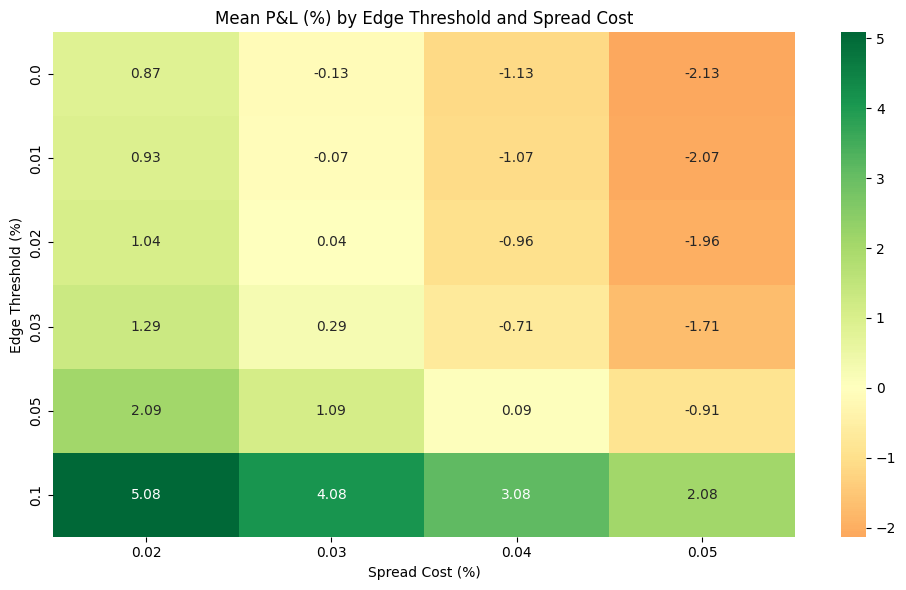

In [22]:
# Pivot for heatmap
if len(sens_df) > 0:
    pnl_pivot = sens_df.pivot(
        index='edge_threshold',
        columns='spread_cost',
        values='mean_pnl'
    ) * 100  # Convert to percentage
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pnl_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
    plt.title('Mean P&L (%) by Edge Threshold and Spread Cost')
    plt.xlabel('Spread Cost (%)')
    plt.ylabel('Edge Threshold (%)')
    plt.tight_layout()
    plt.savefig(DATA_DIR / 'sensitivity_heatmap.png', dpi=100)
    plt.show()

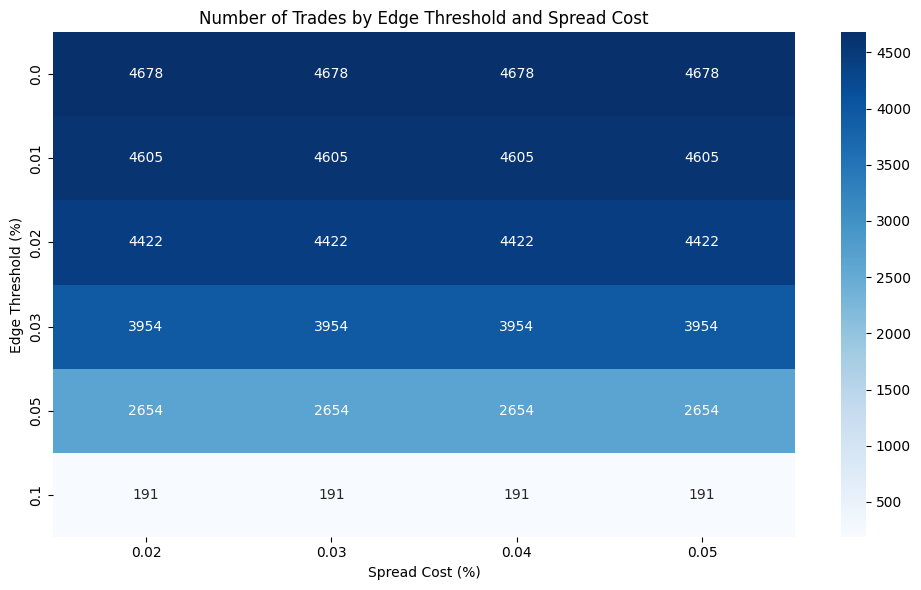

In [23]:
# Trade count heatmap
if len(sens_df) > 0:
    trades_pivot = sens_df.pivot(
        index='edge_threshold',
        columns='spread_cost',
        values='n_trades'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(trades_pivot, annot=True, fmt='d', cmap='Blues')
    plt.title('Number of Trades by Edge Threshold and Spread Cost')
    plt.xlabel('Spread Cost (%)')
    plt.ylabel('Edge Threshold (%)')
    plt.tight_layout()
    plt.show()

## 6. Performance by Segment

In [24]:
# Use optimal threshold (7%) for all remaining analysis
OPTIMAL_THRESHOLD = 0.07

# Performance by timing
sim = simulate_strategy(oos, edge_threshold=OPTIMAL_THRESHOLD, spread_cost_pct=0.03)
trades = sim[sim['take_trade']].copy()

print(f"=== Performance Analysis (using {OPTIMAL_THRESHOLD:.0%} edge threshold) ===\n")
print(f"Total trades: {len(trades)}")

if 'timing' in trades.columns:
    timing_perf = trades.groupby('timing').agg({
        'pnl': ['count', 'mean', 'std'],
        'target_move': 'mean',
    }).round(4)
    timing_perf.columns = ['n_trades', 'mean_pnl', 'std_pnl', 'avg_move']
    timing_perf['win_rate'] = trades.groupby('timing')['pnl'].apply(lambda x: (x > 0).mean())
    
    print("\n=== Performance by Timing ===")
    print(timing_perf)

=== Performance Analysis (using 7% edge threshold) ===

Total trades: 1277

=== Performance by Timing ===
         n_trades  mean_pnl  std_pnl  avg_move  win_rate
timing                                                  
AMC           912    0.0216   0.1190    0.1227  0.481360
BMO           204    0.0170   0.0978    0.0920  0.465686
unknown       161    0.0373   0.1118    0.1077  0.521739


In [25]:
# Performance by edge bucket
trades['edge_bucket'] = pd.cut(
    trades['edge'],
    bins=[0, 0.02, 0.05, 0.10, 0.20, 1.0],
    labels=['0-2%', '2-5%', '5-10%', '10-20%', '20%+']
)

edge_perf = trades.groupby('edge_bucket', observed=True).agg({
    'pnl': ['count', 'mean', 'std'],
}).round(4)
edge_perf.columns = ['n_trades', 'mean_pnl', 'std_pnl']
edge_perf['win_rate'] = trades.groupby('edge_bucket', observed=True)['pnl'].apply(lambda x: (x > 0).mean())

print("\n=== Performance by Edge Bucket ===")
print(edge_perf)


=== Performance by Edge Bucket ===
             n_trades  mean_pnl  std_pnl  win_rate
edge_bucket                                       
5-10%            1086    0.0197   0.1107  0.476059
10-20%            191    0.0408   0.1361  0.528796


## 7. Drawdown Analysis

In [26]:
# Compute drawdowns (using trades from optimal threshold above)
trades_sorted = trades.sort_values('earnings_date').copy()
trades_sorted['cum_pnl'] = trades_sorted['pnl'].cumsum()
trades_sorted['high_water'] = trades_sorted['cum_pnl'].cummax()
trades_sorted['drawdown'] = trades_sorted['cum_pnl'] - trades_sorted['high_water']

print(f"=== Drawdown Analysis ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(f"Max drawdown: {trades_sorted['drawdown'].min():.2%}")
print(f"Final P&L: {trades_sorted['cum_pnl'].iloc[-1]:.2%}")
print(f"Recovery ratio: {trades_sorted['cum_pnl'].iloc[-1] / abs(trades_sorted['drawdown'].min()):.2f}x")

=== Drawdown Analysis (7% threshold) ===
Max drawdown: -147.91%
Final P&L: 2917.92%
Recovery ratio: 19.73x


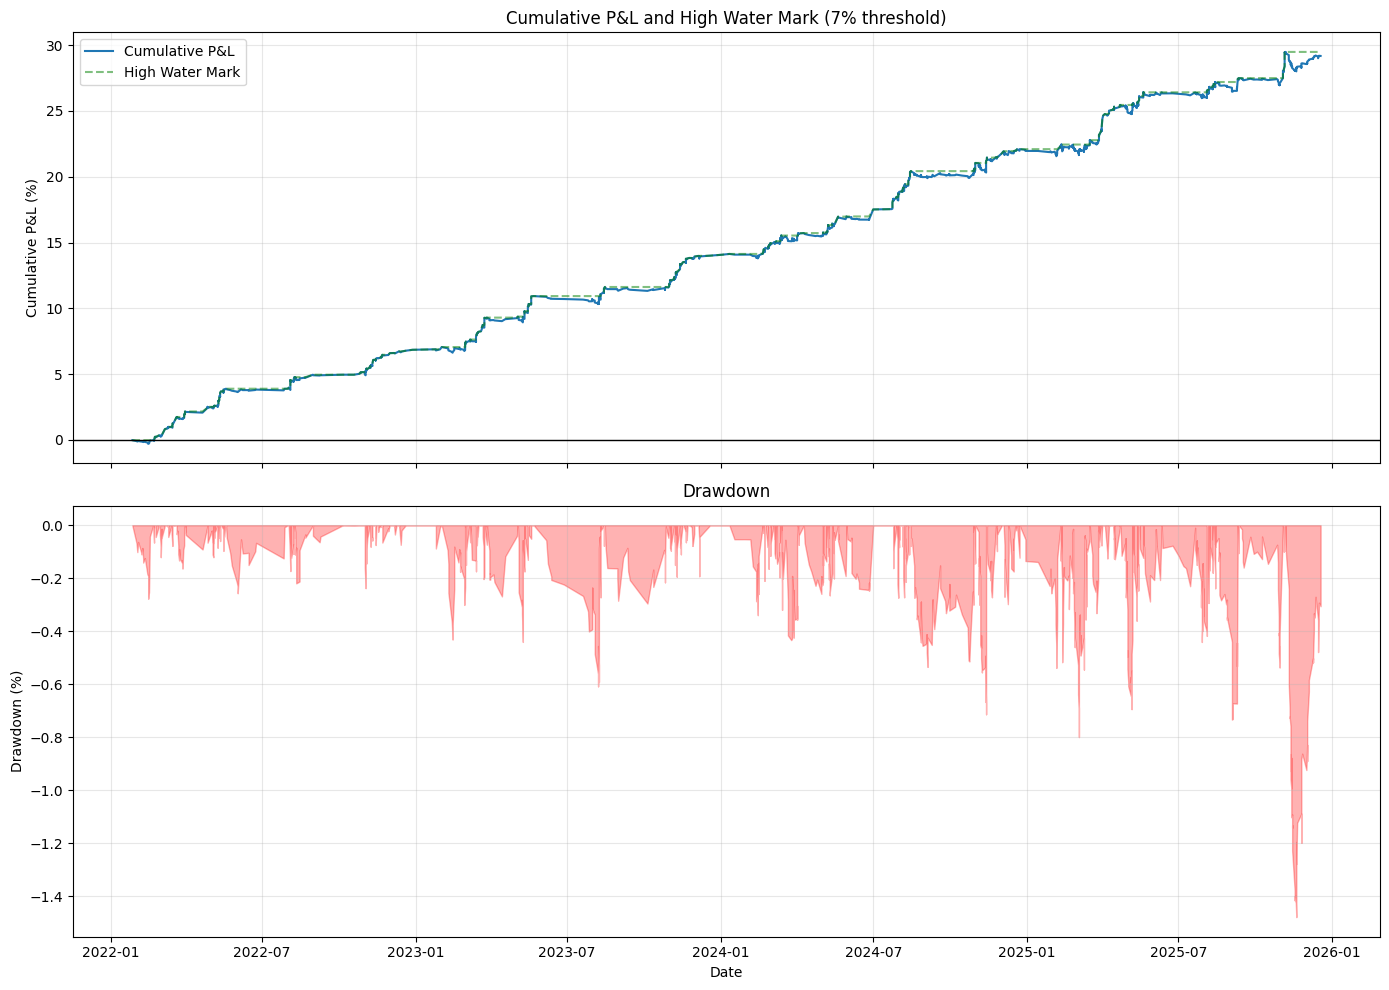

In [27]:
# Plot drawdown (using optimal threshold)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Cumulative P&L
ax1.plot(trades_sorted['earnings_date'], trades_sorted['cum_pnl'], label='Cumulative P&L')
ax1.plot(trades_sorted['earnings_date'], trades_sorted['high_water'], '--', color='green', alpha=0.5, label='High Water Mark')
ax1.axhline(0, color='black', linestyle='-', linewidth=1)
ax1.set_ylabel('Cumulative P&L (%)')
ax1.set_title(f'Cumulative P&L and High Water Mark ({OPTIMAL_THRESHOLD:.0%} threshold)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown
ax2.fill_between(trades_sorted['earnings_date'], 0, trades_sorted['drawdown'], color='red', alpha=0.3)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.set_title('Drawdown')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'drawdown_analysis.png', dpi=100)
plt.show()

## 8. Sharpe Ratio Estimation

In [28]:
# Daily aggregation for Sharpe (using optimal threshold trades)
daily_pnl = trades.groupby('earnings_date')['pnl'].sum()

# Annualized Sharpe (assuming ~250 trading days)
# But we only trade on earnings days, so adjust
n_trading_days = len(daily_pnl)
n_calendar_days = (trades['earnings_date'].max() - trades['earnings_date'].min()).days
trades_per_year = n_trading_days * 252 / n_calendar_days if n_calendar_days > 0 else 100

mean_daily = daily_pnl.mean()
std_daily = daily_pnl.std()

sharpe = (mean_daily / std_daily) * np.sqrt(trades_per_year) if std_daily > 0 else 0

print(f"=== Sharpe Ratio Estimation ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(f"Trading days: {n_trading_days}")
print(f"Calendar days: {n_calendar_days}")
print(f"Est. trades per year: {trades_per_year:.0f}")
print(f"\nMean daily P&L: {mean_daily:.2%}")
print(f"Std daily P&L: {std_daily:.2%}")
print(f"\nAnnualized Sharpe: {sharpe:.2f}")

=== Sharpe Ratio Estimation (7% threshold) ===
Trading days: 503
Calendar days: 1421
Est. trades per year: 89

Mean daily P&L: 5.80%
Std daily P&L: 18.93%

Annualized Sharpe: 2.89


## Summary

Key findings:
1. **Calibration**: [Check results above]
2. **Strategy P&L**: [Check results above]
3. **Optimal threshold**: Edge threshold and spread cost sensitivity
4. **Drawdowns**: Maximum drawdown and recovery
5. **Sharpe ratio**: Risk-adjusted returns

### Recommendations

Based on the analysis:
- [Insert recommendations based on results]

### Next Steps
1. Run feature engineering notebook to generate features
2. Run model training notebook to train models
3. Run this calibration notebook to validate
4. If calibration is acceptable, proceed to Phase 0 paper trading

In [29]:
# Save summary stats (using optimal threshold)
summary = {
    'n_oos_samples': len(oos),
    'n_trades': len(trades),
    'edge_threshold': OPTIMAL_THRESHOLD,
    'mean_pnl': trades['pnl'].mean(),
    'win_rate': (trades['pnl'] > 0).mean(),
    'max_drawdown': trades_sorted['drawdown'].min(),
    'sharpe': sharpe,
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(DATA_DIR / 'backtest_summary.csv', index=False)

print(f"\n=== Summary Saved ({OPTIMAL_THRESHOLD:.0%} threshold) ===")
print(summary_df.T)


=== Summary Saved (7% threshold) ===
                           0
n_oos_samples   60257.000000
n_trades         1277.000000
edge_threshold      0.070000
mean_pnl            0.022850
win_rate            0.483947
max_drawdown       -1.479143
sharpe              2.894193
